# LAB | Hyperparameter Tuning

**Load the data**

Finally step in order to maximize the performance on your Spaceship Titanic model.

The data can be found here:

https://raw.githubusercontent.com/data-bootcamp-v4/data/main/spaceship_titanic.csv

Metadata

https://github.com/data-bootcamp-v4/data/blob/main/spaceship_titanic.md

So far we've been training and evaluating models with default values for hyperparameters.

Today we will perform the same feature engineering as before, and then compare the best working models you got so far, but now fine tuning it's hyperparameters.

In [1]:
#Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
spaceship = pd.read_csv("https://raw.githubusercontent.com/data-bootcamp-v4/data/main/spaceship_titanic.csv")
spaceship.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


Now perform the same as before:
- Feature Scaling
- Feature Selection


In [3]:
spaceship.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [57]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='most_frequent')
spaceship_clean = pd.DataFrame(imputer.fit_transform(spaceship), columns=spaceship.columns)

In [58]:
spaceship_clean.isna().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
Transported     0
dtype: int64

In [5]:
spaceship_clean['Cabin'].unique()

array(['B/0/P', 'F/0/S', 'A/0/S', ..., 'G/1499/S', 'G/1500/S', 'E/608/S'],
      dtype=object)

In [6]:
spaceship_trans = spaceship_clean

In [7]:
spaceship_trans['Cabin'] = spaceship_clean['Cabin'].str[0]
spaceship_trans['Cabin'].unique()

C:\Users\Carlota\AppData\Local\Temp\ipykernel_11232\2910688578.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spaceship_trans['Cabin'] = spaceship_clean['Cabin'].str[0]


array(['B', 'F', 'A', 'G', 'E', 'C', 'D', 'T'], dtype=object)

In [9]:
spaceship_trans = spaceship_trans.drop(columns=["PassengerId", "Name"])

In [10]:
spaceship_trans = pd.get_dummies(spaceship_trans, columns=['Destination', 'VIP', 'HomePlanet','CryoSleep', 'Cabin'])

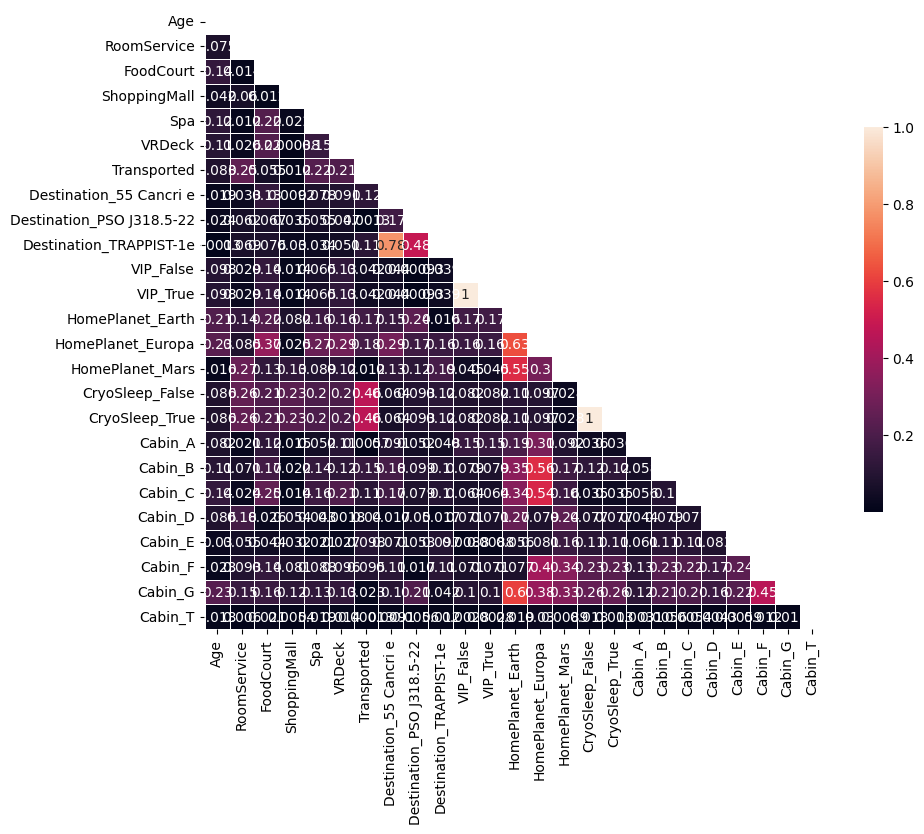

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
corr=np.abs(spaceship_trans.corr())

#Set up mask for triangle representation
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,  vmax=1,square=True, linewidths=.5, cbar_kws={"shrink": .5},annot = corr)

plt.show()

In [13]:
features = spaceship_trans.drop(columns=["Transported"], axis = 1)
target = spaceship_trans["Transported"]

In [14]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=0)

In [16]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# normalize data
normalizer = MinMaxScaler()

normalizer.fit(X_train)

MinMaxScaler()

In [17]:
X_train_norm = normalizer.transform(X_train)

X_test_norm = normalizer.transform(X_test)

In [19]:
X_train_norm = pd.DataFrame(X_train_norm, columns = X_train.columns)
X_train_norm.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,VIP_False,...,CryoSleep_False,CryoSleep_True,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T
0,0.405063,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.050633,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.379747,0.00000,0.007916,0.000000,0.051276,0.000000,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.215190,0.00131,0.000000,0.046111,0.016378,0.000049,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.329114,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [20]:
X_test_norm = pd.DataFrame(X_test_norm, columns = X_test.columns)
X_test_norm.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,VIP_False,...,CryoSleep_False,CryoSleep_True,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T
0,0.632911,0.0,0.000000,0.0,0.00000,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.227848,0.0,0.000000,0.0,0.00000,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.189873,0.0,0.000000,0.0,0.00000,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.658228,0.0,0.000000,0.0,0.00000,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.784810,0.0,0.054775,0.0,0.07774,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# other method
from sklearn.preprocessing import MinMaxScaler, StandardScaler
normalizer = StandardScaler()
normalizer.fit(X_train)
X_train_norm2 = normalizer.transform(X_train)
X_test_norm2 = normalizer.transform(X_test)
X_train_norm2 = pd.DataFrame(X_train_norm, columns = X_train.columns)
X_test_norm2 = pd.DataFrame(X_test_norm, columns = X_test.columns)

- Now let's use the best model we got so far in order to see how it can improve when we fine tune it's hyperparameters.

In [25]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier
# Initialize a Random Forest
forest = RandomForestClassifier(n_estimators=100,
                             max_depth=20)
# Training the model
forest.fit(X_train_norm, y_train)
# Evaluate the model
pred = forest.predict(X_test_norm)



- Evaluate your model

In [26]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def calcularMatrizConfusion(y_test, y_pred):    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(1,figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion matrix')
    plt.show()

Accuracy 0.7904689863842662
              precision    recall  f1-score   support

       False       0.78      0.81      0.79       661
        True       0.80      0.77      0.79       661

    accuracy                           0.79      1322
   macro avg       0.79      0.79      0.79      1322
weighted avg       0.79      0.79      0.79      1322



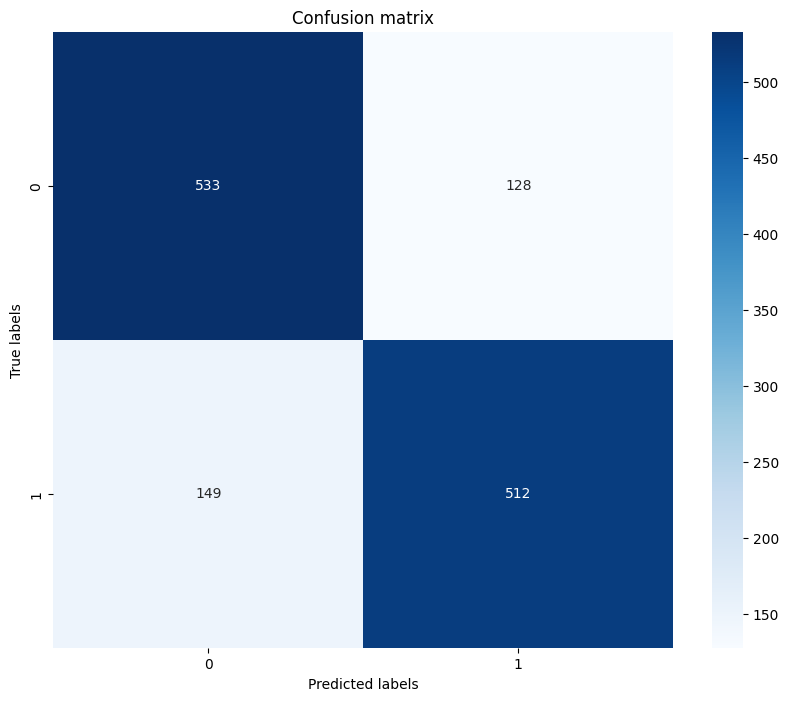

In [28]:
from sklearn.metrics import accuracy_score, classification_report
acc_random_forest = accuracy_score( y_test, pred)
print("Accuracy", accuracy_score( y_test, pred))
print(classification_report(y_test, pred))
calcularMatrizConfusion(y_test, pred)

**Grid/Random Search**

For this lab we will use Grid Search.

- Define hyperparameters to fine tune.

In [42]:
grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


- Run Grid Search

In [35]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor,AdaBoostRegressor, GradientBoostingRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [48]:
model_randomforest = RandomForestClassifier(random_state=42)

In [49]:
model = GridSearchCV(estimator = model_randomforest, param_grid = grid, cv=5)

In [50]:
model.fit(X_train_norm, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 10, 20, 30, 50],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 50, 100, 200]})

In [51]:
model.best_params_

{'max_depth': 10,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 50}

In [52]:
best_model = model.best_estimator_

- Evaluate your model

In [55]:
pred = best_model.predict(X_test_norm)

acc_random_forest = accuracy_score( y_test, pred)
print("Accuracy", accuracy_score( y_test, pred))
print(classification_report(y_test, pred))

Accuracy 0.7889561270801816
              precision    recall  f1-score   support

       False       0.79      0.79      0.79       661
        True       0.79      0.79      0.79       661

    accuracy                           0.79      1322
   macro avg       0.79      0.79      0.79      1322
weighted avg       0.79      0.79      0.79      1322



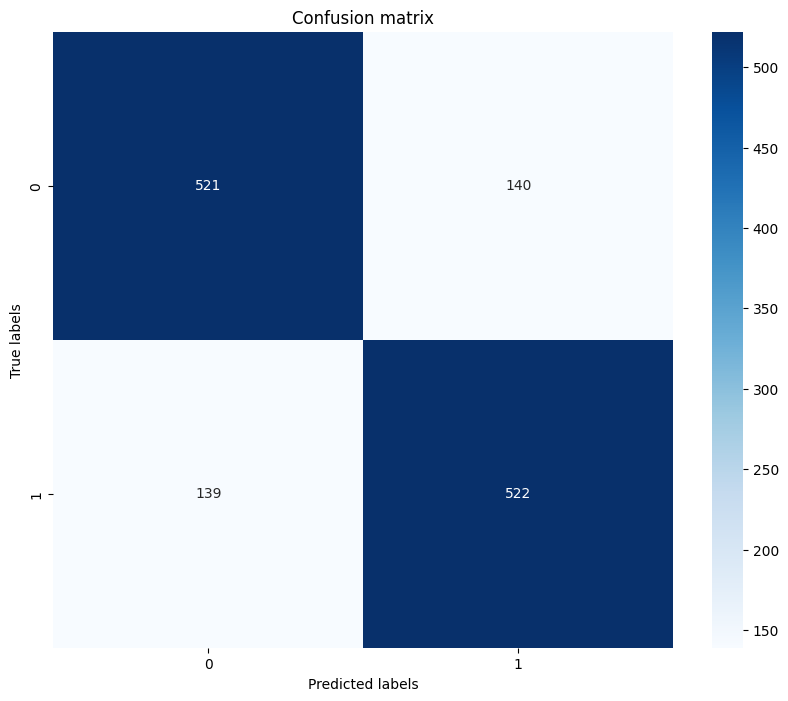

In [56]:
calcularMatrizConfusion(y_test, pred)